In [3]:
import pandas as pd
df = pd.read_csv('cleaned_data.csv')

In [4]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'yr_built', 'city',
       'month_sold', 'house_age', 'renovation_age', 'price_per_sqft',
       'basement_category', 'renovation_status', 'basement_status'],
      dtype='object')

In [5]:
df = df.drop(['house_age', 'month_sold', 'basement_category', 'city'], axis=1)

In [6]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,yr_built,renovation_age,price_per_sqft,renovation_status,basement_status
0,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,1340,2008,6,280.597015,0,0
1,324000.0,3.0,2.25,998,904,2.0,0,0,3,798,2007,7,324.649299,0,1
2,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,1600,1979,35,179.705882,0,1
3,320000.0,3.0,2.50,2130,6969,2.0,0,0,3,2130,2003,11,150.234742,0,0
4,875000.0,4.0,2.00,2520,6000,1.0,0,0,3,1400,1921,7,347.222222,1,1


In [7]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'yr_built',
       'renovation_age', 'price_per_sqft', 'renovation_status',
       'basement_status'],
      dtype='object')

###  1 多重共线性的检验，检验vif值，注意它通常是对 数值型数据，应该避免对虚拟变量处理

In [8]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [9]:
dff = df.drop(columns=['price'])
X = sm.add_constant(dff)  # 添加常数项（intercept）

# 计算 VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]
vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)

vif_data.head(14)

,feature,VIF
0,sqft_above,15.355609
1,sqft_living,15.281073
2,basement_status,3.963955
3,bathrooms,3.147647
4,yr_built,2.662540
5,floors,2.353004
6,renovation_age,1.885062
7,bedrooms,1.761993
8,condition,1.623041
9,renovation_status,1.622671


### 2 线性回归

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import numpy as np

df = df.copy()
df['sqft_lot'] = np.log(df['sqft_lot'])

X = df.drop(columns=['price', 'sqft_above'])
Y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {round(mse, 3)}')
print(f'R^2 Score: {round(r2, 3)}')

coefficients = model.coef_
print(f"回归系数: {list(map(lambda x: round(x, 3), coefficients))}")
intercept = model.intercept_
print(f"截距: {round(intercept, 3)}")

X_train_sm = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_sm).fit()

residuals = y_test - y_pred

within_range = (y_pred >= 0.8 * y_test) & (y_pred <= 1.2 * y_test)
proportion_within_range = np.mean(within_range)
print(f'预测值在真实值的0.8到1.2倍之间的比例: {round(proportion_within_range, 3)}')

within_range = (y_pred >= 0.7 * y_test) & (y_pred <= 1.3 * y_test)
proportion_within_range = np.mean(within_range)
print(f'预测值在真实值的0.7到1.3倍之间的比例: {round(proportion_within_range, 3)}')

Mean Squared Error: 4419506157.453
R^2 Score: 0.918
回归系数: [np.float64(5069.542), np.float64(15773.773), np.float64(235.981), np.float64(15256.377), np.float64(11848.938), np.float64(-27591.362), np.float64(11740.255), np.float64(4384.029), np.float64(-107.762), np.float64(46.892), np.float64(1729.495), np.float64(181.772), np.float64(14321.973)]
截距: -435516.592
预测值在真实值的0.8到1.2倍之间的比例: 0.859
预测值在真实值的0.7到1.3倍之间的比例: 0.908


In [11]:
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     2149.
Date:                Mon, 19 May 2025   Prob (F-statistic):               0.00
Time:                        15:15:59   Log-Likelihood:                -36433.
No. Observations:                2883   AIC:                         7.289e+04
Df Residuals:                    2869   BIC:                         7.298e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -4.355e+05   1.52e+0

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import numpy as np

df = df.copy()
df['sqft_lot'] = np.log(df['sqft_lot'])

X = df.drop(columns=['price', 'sqft_above','waterfront' , 'renovation_age', 'renovation_status', 'yr_built'])
Y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {round(mse, 3)}')
print(f'R^2 Score: {round(r2, 3)}')

coefficients = model.coef_
print(f"回归系数: {list(map(lambda x: round(x, 3), coefficients))}")
intercept = model.intercept_
print(f"截距: {round(intercept, 3)}")

X_train_sm = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_sm).fit()

residuals = y_test - y_pred

within_range = (y_pred >= 0.8 * y_test) & (y_pred <= 1.2 * y_test)
proportion_within_range = np.mean(within_range)
print(f'预测值在真实值的0.8到1.2倍之间的比例: {round(proportion_within_range, 3)}')

within_range = (y_pred >= 0.7 * y_test) & (y_pred <= 1.3 * y_test)
proportion_within_range = np.mean(within_range)
print(f'预测值在真实值的0.7到1.3倍之间的比例: {round(proportion_within_range, 3)}')

print(model_sm.summary())

Mean Squared Error: 4414590322.767
R^2 Score: 0.918
回归系数: [np.float64(5512.048), np.float64(13448.633), np.float64(235.632), np.float64(136571.715), np.float64(11895.77), np.float64(11330.836), np.float64(6352.587), np.float64(1737.505), np.float64(16092.819)]
截距: -814307.117
预测值在真实值的0.8到1.2倍之间的比例: 0.863
预测值在真实值的0.7到1.3倍之间的比例: 0.908
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     3106.
Date:                Mon, 19 May 2025   Prob (F-statistic):               0.00
Time:                        15:15:59   Log-Likelihood:                -36434.
No. Observations:                2883   AIC:                         7.289e+04
Df Residuals:                    2873   BIC:                         7.295e+04
Df Model:                        

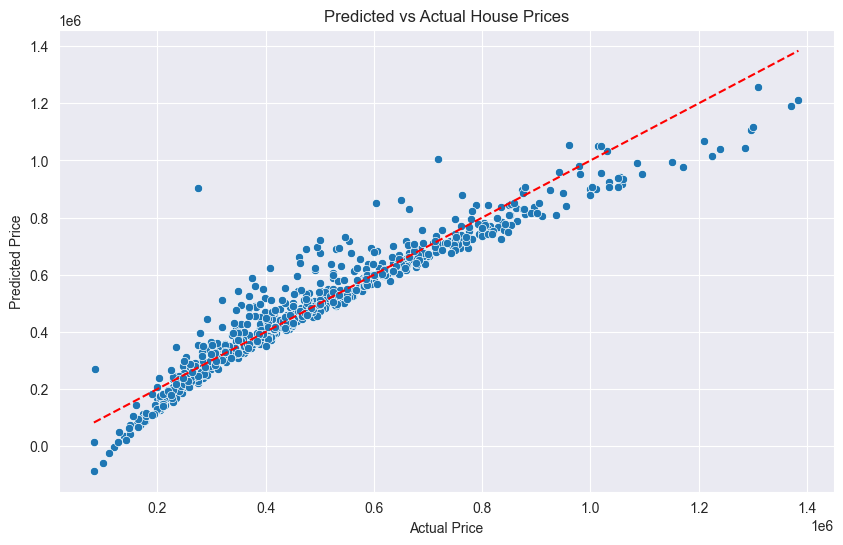

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual House Prices')
plt.grid(True)
plt.show()

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor, plot_importance

In [15]:
# 复制原始数据防止污染
df = df.copy()

# 对数变换（处理偏态分布）
df['sqft_lot'] = np.log(df['sqft_lot'])

# 分离特征与目标
X = df.drop(columns=['price'])
y = df['price']

# 区分数值型与类别型特征
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

# 构建预处理器：数值标准化 + 类别独热编码
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


In [16]:
# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 初始化模型
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# 构建总 pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# 设置参数网格
param_grid = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.05, 0.1],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

# 网格搜索调参
grid_search = GridSearchCV(
    pipeline, param_grid, scoring='r2',
    cv=3, verbose=1, n_jobs=1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'yr_built',
       'renovation_age', 'price_per_sqft', 'renovation_status',
       'basement_status'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(han...
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=100,
                                                     n_jobs=-1,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=1,
             param_grid={'model__colsample_bytree': [0.8, 1.0],
                         'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [50, 100],
                         'model__subsample': [0.8, 1.0]},
             scoring='r2', verbose=1)

In [17]:
# 预测与评估
y_pred = grid_search.best_estimator_.predict(X_test)

print(f"Model R^2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

# 交叉验证评估全体数据
scores = cross_val_score(grid_search.best_estimator_, X, y, cv=5, scoring='r2')
print("Cross-validated R² scores:", scores)
print("Mean R²:", scores.mean())

Model R^2 Score: 0.9971
MAE: 7743.26
RMSE: 12425.23
Cross-validated R² scores: [0.9967922  0.996528   0.99668708 0.99670595 0.99429877]
Mean R²: 0.9962023979945306


<Figure size 1500x800 with 0 Axes>

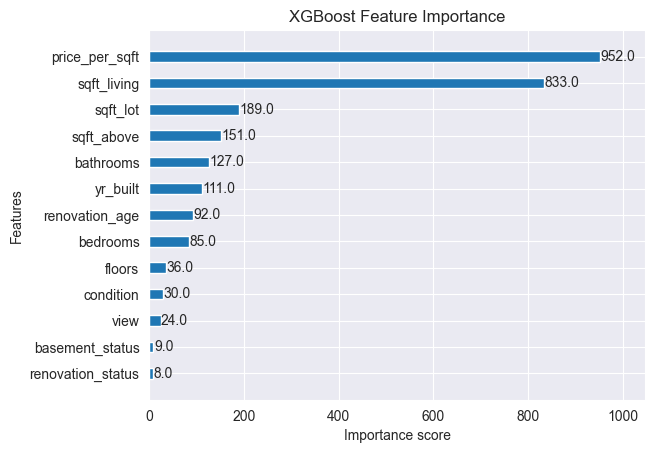

In [24]:
# 提取最佳模型
best_model = grid_search.best_estimator_.named_steps['model']

# 获取原始特征名（不包括 OneHot）
raw_feature_names = X.columns.tolist()

# 为 XGBoost 模型绑定特征名（仅对 plot_importance 有效）
booster = best_model.get_booster()
booster.feature_names = raw_feature_names  # 注意：此处 X 不能 OneHot

# 绘图
plt.figure(figsize=(15, 8))
plot_importance(booster, max_num_features=20, height=0.4)
plt.title("XGBoost Feature Importance")
plt.savefig(r"D:\\数据分析\\ANSTProject\\ahp\\XGBoost Feature Importance.png", )
plt.show()


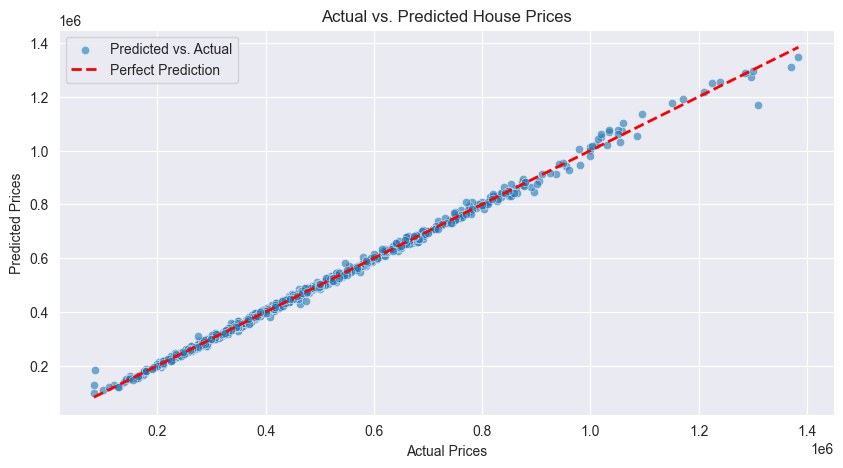

In [25]:
# 保存模型
with open("xgboost_house_price_model.pkl", "wb") as f:
    pickle.dump(grid_search.best_estimator_, f)

# 实际 vs 预测可视化
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label="Predicted vs. Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction", linewidth=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted House Prices")
plt.legend()
plt.savefig(r"D:\数据分析\ANSTProject\ahp\Actual vs. Predicted House Prices.png")
plt.show()


In [39]:
def predict_house_price(sample):
    sample_df = pd.DataFrame([sample])
    sample_df = sample_df[X_train.columns] 
    predicted_log_price = grid_search.best_estimator_.predict(sample_df)
    predicted_price = np.expm1(predicted_log_price) if np.any(y_train <= 0) else predicted_log_price
    return predicted_price[0]

sample_house = {
    'yr_built': 100,
    'bedrooms': 5,
    'bathrooms': 2,
    'sqft_living': 500,
    'sqft_lot': 260,
    'floors': 2,
    'waterfront': 0,
    'view': 24,
    'condition': 30,
    'sqft_above': 151,
    'renovation_age': 92,
    'price_per_sqft': 952,
    'renovation_status': 1,
    'basement_status': 1
}

print(f"Predicted Price: ${predict_house_price(sample_house):,.2f}")

Predicted Price: $395,183.72
